# 1 - Perkenalan 

Nama : Husain Tsabit Abdur Rahim

Batch : ftds batch 016 - rmt

dataset : https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset

problem : Membuat model Computer vision untuk image classification dalam menentukan sepatu tersebut tergolong kedalam brand nike atau adidas.

Objective : Melakukan klasifikasi jenis brand pada sepatu.

## Latar Belakang

Tujuan dari assignment ini adalah untuk menjelaskan tentang bagaimana menggunakan model CNN (Convolutional Neural Network) untuk mengklasifikasikan jenis brand sepatu. Klasifikasi jenis brand sepatu merupakan salah satu metode yang dapat digunakan untuk mengelompokkan sepatu berdasarkan merek atau pada kesempatan kali ini yaitu merek adidas atau nike. Dengan menggunakan model CNN, kita dapat dengan mudah dan cepat mengklasifikasikan sepatu ke dalam kelompok merek yang sesuai. Hal ini akan memberikan penjelasan tentang bagaimana model CNN dapat digunakan untuk mengklasifikasikan jenis brand sepatu, harapannya yaitu bisa mengetahui karakteristik pengguna brand tersebut dari segi penampilan ataupun keterkaitan style fashion tiap pengguna.

# 2 - Import Pustaka

In [1]:
# libraries
import pandas as pd
import numpy as np
import json 
import os
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import cv2
import random
import os
import io

# model 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping (Stop training when a monitored metric has stopped improving)
# ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # mengatur dan memperluas dataset gambar.
from tensorflow.keras.models import load_model

#inference
from google.colab import files
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# metrics model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [2]:
# api key
api_key = {
'username':"username" ,
'key':"some_api_key"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

referensi stackoverflow : https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

In [3]:
# membuat folder di kaggle root
!mkdir -p ~/.kaggle
# copy paste kaggle.json ke folder kaggle  
!cp kaggle.json ~/.kaggle 

# membuat folder kaggle yang bukan di root
!mkdir ./kaggle 
# memindahkan file kaggle.json ke folder kaggle yang telah dibuat
!mv ./kaggle.json ./kaggle 

In [4]:
# mengubah perizinan dalam direktori, hanya pemilik file yang memiliki akses baca dan tulis ke file
!chmod 600 ~/.kaggle/kaggle.json 
#cek list data yang ada di folder kaggle
!ls ~/.kaggle 

kaggle.json


In [5]:
# download dataset
!kaggle datasets download -d ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset

 82% 21.0M/25.7M [00:01<00:00, 19.9MB/s]
100% 25.7M/25.7M [00:01<00:00, 17.7MB/s]


In [6]:
# unzip folder yang telah didownload dari kaggle
!unzip -q /content/nike-adidas-shoes-for-image-classification-dataset.zip -d images

In [7]:
# menampilkan list direktori
os.listdir('/content/images')

['validation', 'labelnames.csv', 'test', 'train']

selanjutnya yaitu mendefinisikan path untuk dataset.

In [8]:
# path dataset
main_path = '/content/images'

# path data train
train_path = os.path.join(main_path, 'train')

# path data validation
val_path = os.path.join(main_path, 'validation')

# path data test
test_path = os.path.join(main_path, 'test')

kemudian mengecek jumlah dataset dalam train, validation, dan test

In [9]:
# Mengecek jumlah dataset dalam train
print('train set: \n' + '='*50)
nike = len(os.listdir(os.path.join(train_path, 'nike'))) # mendefinisikan label Nike
adidas = len(os.listdir(os.path.join(train_path, 'adidas'))) # mendefinisikan label Adidas
print(f'jumlah sepatu Nike= {nike}')
print(f'jumlah sepatu Adidas= {adidas}')

train set: 
jumlah sepatu Nike= 230
jumlah sepatu Adidas= 230


In [10]:
# Mengecek jumlah dataset dalam validation
print('validation set: \n' + '='*50)
nike = len(os.listdir(os.path.join(val_path, 'nike'))) # mendefinisikan label Nike
adidas = len(os.listdir(os.path.join(val_path, 'adidas'))) # mendefinisikan label Adidas
print(f'jumlah sepatu Nike= {nike}')
print(f'jumlah sepatu Adidas= {adidas}')

validation set: 
jumlah sepatu Nike= 28
jumlah sepatu Adidas= 27


In [11]:
# Mengecek jumlah dataset dalam test
print('test set: \n' + '='*50)
nike = len(os.listdir(os.path.join(test_path, 'nike'))) # mendefinisikan label Nike
adidas = len(os.listdir(os.path.join(test_path, 'adidas'))) # mendefinisikan label Adidas
print(f'jumlah sepatu Nike= {nike}')
print(f'jumlah sepatu Adidas= {adidas}')

test set: 
jumlah sepatu Nike= 30
jumlah sepatu Adidas= 30


In [12]:
# mencari file image dalam direktori

# untuk data train
train_adidas = glob.glob(train_path + '/adidas/*.jpg')
train_nike = glob.glob(train_path + '/nike/*.jpg')

# untuk data validation
val_adidas = glob.glob(val_path + '/adidas/*.jpg')
val_nike = glob.glob(val_path + '/nike/*.jpg')

# untuk data test
test_adidas = glob.glob(test_path + '/adidas/*.jpg')
test_nike = glob.glob(test_path + '/nike/*.jpg')

# 4 - Exploratory Data Analyst

## 4.1 Mengubah bentuk dataset menjadi sebuah dataframe


In [13]:
# membuat fungsi untuk memasukkan data image ke dalam dataframe
def create_df(list_images):
  data=[]
  for image in list_images:
    data.append((image, image.split('/')[-2]))
  return pd.DataFrame(data, columns= ['images', 'label'])

In [14]:
# dataframe train
train_df = create_df(train_adidas + train_nike)
train_df = train_df.sample(frac=1, random_state=21).reset_index(drop=True)

# dataframe validation
val_df = create_df(val_adidas + val_nike)
val_df = val_df.sample(frac=1, random_state=21).reset_index(drop=True)

# dataframe test
test_df = create_df(test_adidas + test_nike)
test_df = test_df.sample(frac=1, random_state=21).reset_index(drop=True)

In [15]:
# menampilkan shape dataframe
print('Size dari train', train_df.shape)
print('Size dari validation', val_df.shape)
print('Size dari test', test_df.shape)

Size dari train (439, 2)
Size dari validation (54, 2)
Size dari test (59, 2)


In [16]:
# menampilkan dataframe train
train_df

,images,label
0,/content/images/train/nike/Image_34.jpg,nike
1,/content/images/train/adidas/Adidas (7).jpg,adidas
2,/content/images/train/nike/Image_74.jpg,nike
3,/content/images/train/adidas/Adidas (10).jpg,adidas
4,/content/images/train/nike/Image_207.jpg,nike
...,...,...
434,/content/images/train/nike/Image_71.jpg,nike
435,/content/images/train/adidas/Adidas (69).jpg,adidas
436,/content/images/train/nike/Image_84.jpg,nike
437,/content/images/train/nike/Image_44.jpg,nike


In [17]:
# menampilkan dataframe validation
val_df

,images,label
0,/content/images/validation/adidas/adidas_ (155...,adidas
1,/content/images/validation/nike/Image_300.jpg,nike
2,/content/images/validation/nike/Image_291.jpg,nike
3,/content/images/validation/adidas/adidas_ (150...,adidas
4,/content/images/validation/adidas/adidass_(24)...,adidas
5,/content/images/validation/adidas/adidas_ (153...,adidas
6,/content/images/validation/adidas/adidass_(21)...,adidas
7,/content/images/validation/nike/Image_278.jpg,nike
8,/content/images/validation/adidas/adidas_ (149...,adidas
9,/content/images/validation/nike/Image_274.jpg,nike


In [18]:
# menampilkan dataframe test
test_df

,images,label
0,/content/images/test/adidas/Adidas (23).jpg,adidas
1,/content/images/test/nike/Image_170.jpg,nike
2,/content/images/test/nike/Image_40.jpg,nike
3,/content/images/test/adidas/Adidas (26).jpg,adidas
4,/content/images/test/adidas/aadidas_ (10).jpg,adidas
5,/content/images/test/adidas/aadidas_ (12).jpg,adidas
6,/content/images/test/adidas/aadidas_ (15).jpg,adidas
7,/content/images/test/nike/Image_230.jpg,nike
8,/content/images/test/adidas/aadidas_ (17).jpg,adidas
9,/content/images/test/nike/Image_220.jpg,nike


## 4.2 Membuat visualisasi untuk menampilkan persebaran brand sepatu


In [19]:
# membuat fungsi untuk menampilkan jumlah sepatu berdasarkan brand
def visualize_data(dataframe, label):
  fig, ax = plt.subplots(figsize =(8, 5))
  ax = sns.countplot(x='label', data=dataframe, palette='flare')
  ax.set_title('Data Distribution')
  ax.set_xlabel('Label')
  ax.set_ylabel('Count')
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2,
                 p.get_height()), ha='center', va='center', 
                size=10, xytext=(0, 5),
                textcoords='offset points')
    
  # setting the label for x-axis
  plt.xlabel('Label', size=14)
  # setting the label for y-axis
  plt.ylabel('Jumlah', size=14)
  # judul visualisasi
  plt.title(f'{label} Distribution', size = 15)
  plt.show()

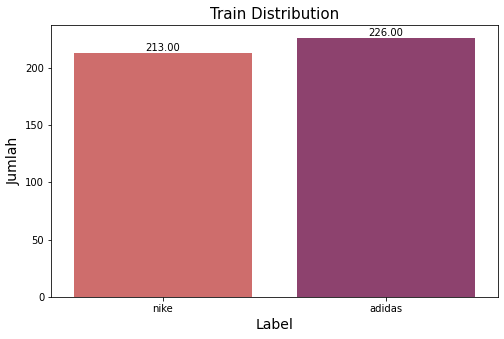

In [20]:
# menampilkan visualisasi jumlah data train
visualize_data(train_df, 'Train')

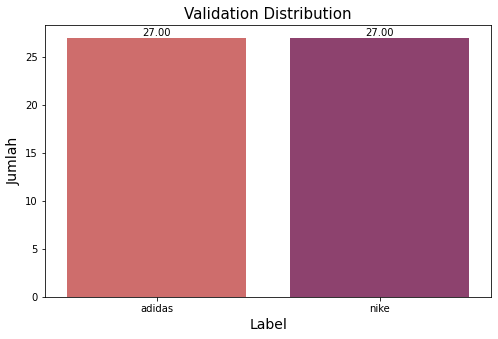

In [21]:
# menampilkan visualisasi jumlah data validation
visualize_data(val_df, 'Validation')

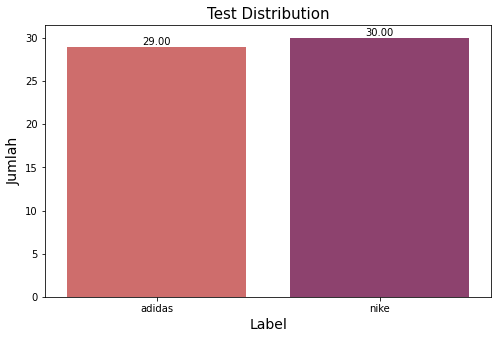

In [22]:
# menampilkan visualisasi jumlah data test
visualize_data(test_df, 'Test')

Analisis distribusi data:
1. train-set : berikut merupakan distribusi data dari train-set, jumlah label yang terdapat pada brand nike yaitu 213 dan brand adidas yaitu 226, keduanya hanya berselisih 13 data, saya rasa dengan perbedaan yang sedikit tidak akan berpengaruh terhadap nilai akurasi yang akan dihasilkan nantinya.
2. validation-set : distribusi pada data validation berjumlah sama, baik nike maupun adidas memiliki jumlah yang sama yaitu 27.
3. sedangkan distribusi data pada test-set data memiliki 30 file gambar sepatu brand nike dam untuk yang bermerek adidas berjumlah 29 file, keduanya hanya berselisih 1 data saja.

Menurut saya persebaran label dalam tiap set sudah cukup seimbang sehingga tidak perlu dilakukan handling.



## 4.3 Menampilkan contoh gambar dari dataset

In [23]:
# Mendefinisikan contoh gambar untuk tiap label
adidas_samples = (train_df[train_df['label']=="adidas"]['images'].iloc[:10]).tolist()
nike_samples = (train_df[train_df['label']=='nike']['images'].iloc[:10]).tolist()

# membuat fungsi untuk memvisualisasi sample
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

### 4.3.1 Contoh gambar brand adidas

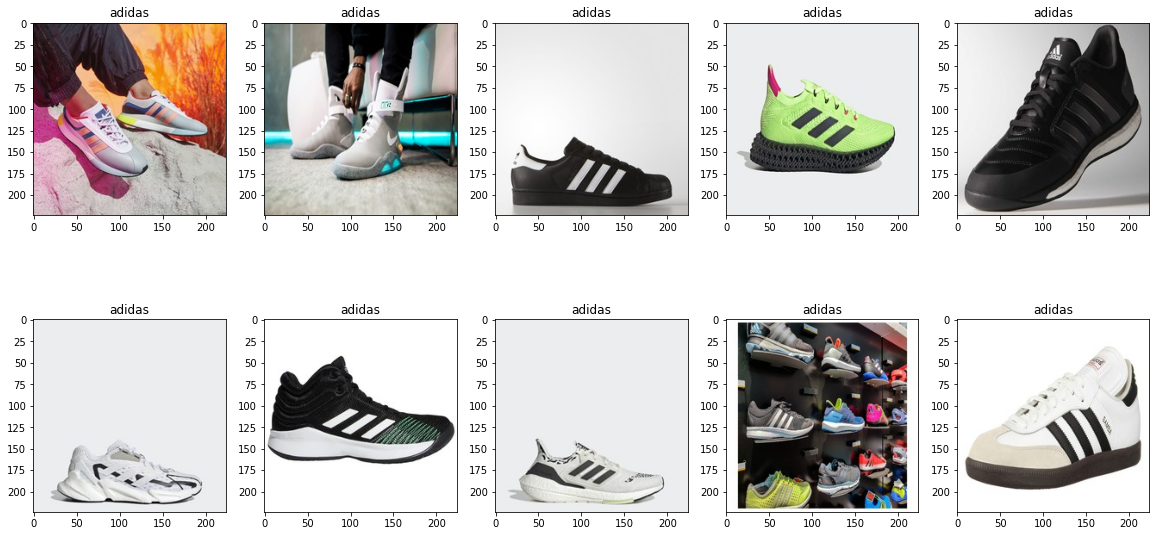

In [24]:
# memvisualisasikan sample adidas
visualize_samples(adidas_samples)

Gambar-gambar diatas merupakan sample dari gambar sepatu bermerk Adidas yang berada pada data train set. Dapat dilihat dari setiap gambar yang ada, hampir seluruh gambar sepatu Adidas terdapat garis stip tiga pada bagian luar dari sepatunya. Namun dapat dilihat pada gambar nomor 2 dari kiri di atas terdapat sepatu nike yang di klasifikasikan adidas, sehingga nanti terdapat kemungkinan salah prediksi yang dihasilkan oleh model.


### 4.3.2 Contoh gambar brand nike

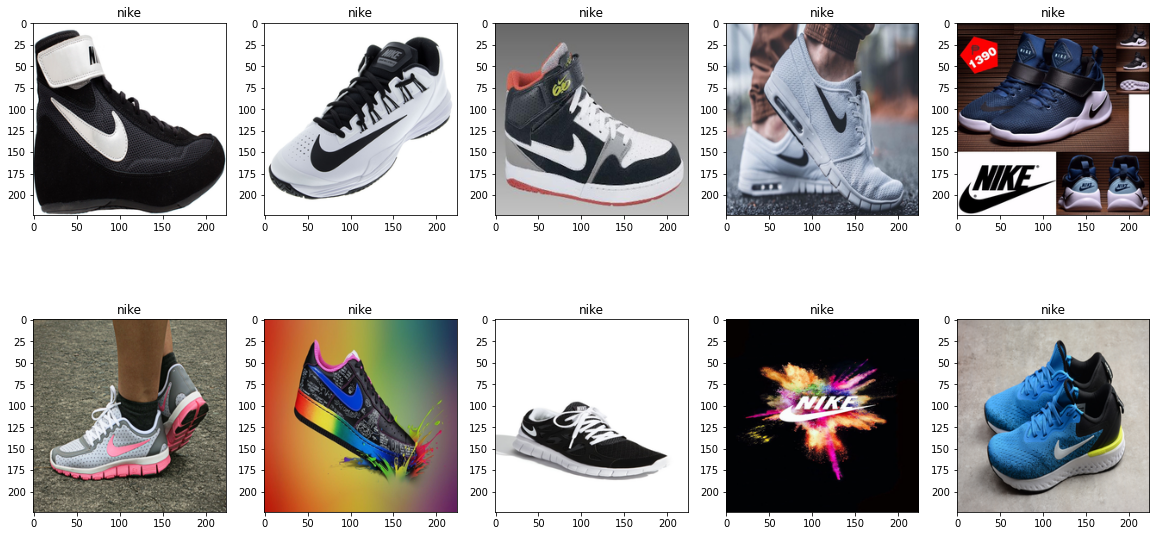

In [25]:
# memvisualisasikan sample nike
visualize_samples(nike_samples)

Sama seperti gambar sepatu Adidas, gambar-gambar dari sepatu Nike juga memiliki logo Nike atau 'centang' pada bagian luar dari sepatu. seringkali sepatu Nike memiliki desain yang lebih modern dan bergaya daripada Adidas, kemungkinan sepatu Nike memang berfokus pada mode dan gaya.

# 5 - Data Preprocessing

## 5.1 Mendefinisikan Fitur dan Target

In [26]:
# fitur
X = 'images'
# target
y = 'label'

## 5.2 Augmentasi

Hal yang dilakukan pertama-tama yaitu menentukan ukuran panjang dan lebar untuk semua image sehingga ukuran input dan output sama, tujuannya untuk mencengah terjadinya error saat data dilakukan training.

In [27]:
# definisikan panjang dan lebar
height_img = 224
width_img = 224

# definisikan random number
SEED = 23

# definisikan batch
BATCH = 10

In [28]:
# Augmentasi data 

# Lakukan augmentasi hanya pada train
train_datagen= ImageDataGenerator(
              rescale= 1./255, #rescale
              rotation_range= 0.2, #rotasi
              width_shift_range= 0.2, #menggeser image dari total width
              height_shift_range=0.2, #menggeser image dari total height
              shear_range= 0.2, #mereganggkan image (bisa vertikal atau horizontal)
              zoom_range= 0.2, #memperbesar
              horizontal_flip= True, #pencerminan
              vertical_flip=True
              )

# Untuk data validation hanya dilakukan rescale
val_datagen= ImageDataGenerator(rescale= 1./255)

# Untuk data test hanya dilakukan rescale
test_datagen= ImageDataGenerator(rescale= 1./255)

Augmentasi merupakan suatu teknik untuk memperluas atau memperbesar data sehingga model dapat melakukan generalisasi. Hal ini dilakukan untuk mencegah adannya overfitting dan model mengenali pola yang bermacam-macam. Augmentasi yang dipilih pada kasus ini adalah :

- Rotasi gambar secara random sejauh 0.2 derajat.
- Menggeser gambar sebanyak 20% dari total width.
- Menggeser gambar sebanyak 20% dari total height.
- Tranvesi/memiringkan gambar sejauh 0.2 derajat.
- Zoom gambar sejauh 0.2.
- Melakukan horizontal flip pada gambar
- Melakukan vertikal flip pada gambar

Augmentasi data hanya dilakukan pada data train, sedangkan untuk val set dan test set hanya dilakukan scaling. karena data validasi dan data test digunakan untuk mengevaluasi model, yang berarti bahwa bentuk aslinya harus utuh untuk mendapatkan kinerja yang realistis dari model kami.

In [29]:
# Menerapkan augmentasi yang dibuat kedalam dataframe
# Augmentasi data hanya dilakukan pada train, sedangkan untuk val set dan test set hanya dilakukan scaling.
# data train
ds_train= train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= True, #shuffle hanya di data train
    seed= SEED)

# data validation
ds_val= val_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)

# data test
ds_test= test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col= X,
    y_col= y,
    target_size= (height_img,width_img),
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED)


Found 439 validated image filenames belonging to 2 classes.
Found 54 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.


In [30]:
train_class = ds_train.class_indices
print('Train Set Class Label : ', train_class)

val_class = ds_val.class_indices
print('Val Set Class Label : ', val_class)

test_class = ds_test.class_indices
print('Test Set Class Label : ', test_class)

Train Set Class Label :  {'adidas': 0, 'nike': 1}
Val Set Class Label :  {'adidas': 0, 'nike': 1}
Test Set Class Label :  {'adidas': 0, 'nike': 1}


kita bisa lihat terdapat 2 label merek sepatu pada tiap dataset, yaitu label 0 untuk adidas dan label 1 untuk nike

# 6 - Model Definition

Definisikan Model CNN yang akan dibuat dengan menggunakan sequential API.

Alasan utama menggunakan sequential API dalam model CNN adalah karena sequential API memudahkan pembuatan arsitektur model yang sederhana dan mudah dipahami. Dengan menggunakan sequential API, kita dapat dengan mudah menambahkan lapisan-lapisan pemrosesan yang diperlukan untuk membuat model CNN, tanpa harus memikirkan bagaimana lapisan-lapisan tersebut terhubung satu sama lain. Selain itu, sequential API juga memungkinkan kita untuk dengan mudah mengatur urutan lapisan-lapisan yang akan diterapkan pada data, sehingga model yang dihasilkan dapat dioptimalkan untuk mencapai performa yang lebih baik.

Kelebihan dari sequential API adalah sebagai berikut:
- Mudah digunakan
- Mempermudah pengaturan urutan lapisan sehingga model yang dihasilkan dapat dioptimalkan untuk mencapai performa yang lebih baik.
- Dapat menangani data dengan dimensi yang berbeda

Kekurangan dari sequential API adalah sebagai berikut:
- Keterbatasan dalam pembuatan arsitektur model, karena hanya dapat digunakan untuk membuat arsitektur model yang sederhana, maka kita tidak dapat membuat arsitektur model yang lebih kompleks dan kustom.
- Tidak dapat menangani data dengan bentuk yang tidak teratur
- Membutuhkan lebih banyak waktu untuk pelatihan.

In [31]:
# mendefinisikan input size
input = [height_img,width_img,3]

In [32]:
# definisikan input size
input = [height_img,width_img,3]

# definisikan model
model = Sequential()
#Conv 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Conv2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten
model.add(Flatten())
#Hidden layer 1
model.add(Dense(16, activation='relu'))
#output layer
model.add(Dense(1, activation='sigmoid'))

Untuk arsitektur model diatas. Model memiliki convolutional layer sejumlah 2 layer dimana layer pertama memiliki filter 3x3 sejumlah 32 filter sedangkan pada layer kedua jumlah filternya 64. Setelah setiap convolusi kita juga melakukan maxpooling dengan pool 2x2 yang bergeser 2 piksel. Selanjutnya hasil convolusi akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 16, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.



In [33]:
# compile
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Kompilasi model adalah proses menyiapkan model machine learning untuk pelatihan. Hal yang dilakukan pada proses kompilasi kali ini yaitu:

-  Loss function adalah fungsi yang digunakan untuk menghitung seberapa baik model memprediksi data. Loss function yang digunakan adalah binary_crossentropy, yang biasanya digunakan untuk klasifikasi biner (prediksi yang hanya memiliki dua kelas).
- Optimizer adalah algoritma yang digunakan untuk menyesuaikan parameter model berdasarkan loss function yang dihitung. Dalam kasus ini, optimizer yang digunakan adalah adam. Adam adalah salah satu jenis optimizer yang digunakan karena kemampuannya untuk menyesuaikan learning rate secara efektif.
- Metrics adalah fungsi yang digunakan untuk mengukur kinerja model. Dalam kasus ini, metric yang digunakan adalah accuracy, yang merupakan persentase sampel yang diprediksi dengan benar oleh model.







In [34]:
# summary dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

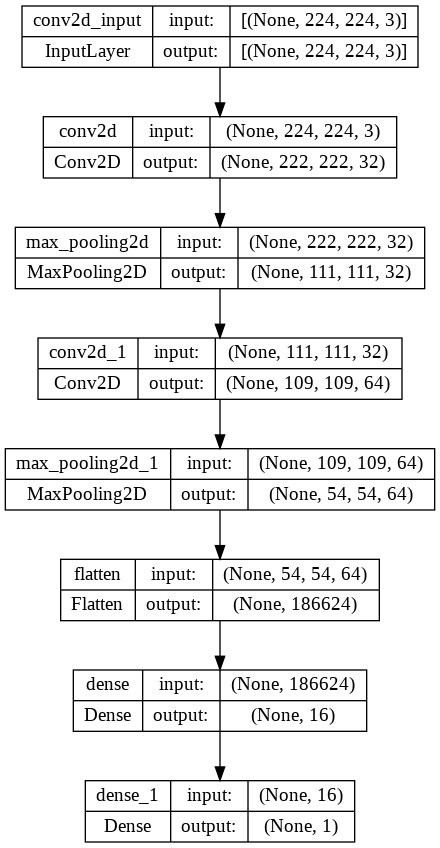

In [35]:
# plot model
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

# 7 - Model Training

Selanjutnya yaitu mendefinisikan callbacks. callbacks adalah parameter yang digunakan untuk menentukan tindakan-tindakan yang harus dilakukan selama pelatihan model. Dalam kasus ini, callbacks terdiri dari dua buah tindakan, yaitu EarlyStopping dan ModelCheckpoint.
- Early stopping digunakan untuk menghentikan training jika val_loss tidak ada peningkatan
- Model check point digunakan untuk menyimpan model terbaik dengan monitoring dari nilai akurasi terbaik 

In [36]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 4, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='accuracy', save_best_only= True)
]   

In [37]:
# melakukan training model dengan 50 epoch
history = model.fit(ds_train, 
                    epochs=50, 
                    validation_data=(ds_val),
                    batch_size= BATCH,
                    callbacks= callbacks,
                    verbose=1)

Epoch 1/50
44/44 [==============================] - 16s 157ms/step - loss: 0.7132 - accuracy: 0.5171 - val_loss: 0.7027 - val_accuracy: 0.5185
Epoch 2/50
44/44 [==============================] - 7s 147ms/step - loss: 0.6943 - accuracy: 0.4875 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 6s 147ms/step - loss: 0.6977 - accuracy: 0.4852 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/50
44/44 [==============================] - 7s 150ms/step - loss: 0.6933 - accuracy: 0.5239 - val_loss: 0.6861 - val_accuracy: 0.5185
Epoch 5/50
44/44 [==============================] - 6s 147ms/step - loss: 0.6939 - accuracy: 0.5171 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
44/44 [==============================] - 6s 147ms/step - loss: 0.6920 - accuracy: 0.5171 - val_loss: 0.6926 - val_accuracy: 0.5185
Epoch 7/50
44/44 [==============================] - 6s 147ms/step - loss: 0.6931 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch

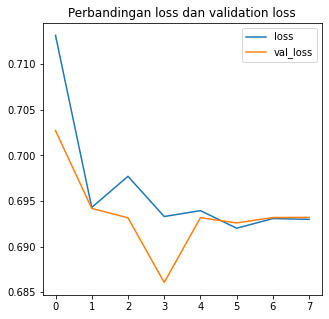

In [38]:
# ubah ke dataframe
metrics_model = pd.DataFrame(history.history)

# plot loss dan validation loss
metrics_model[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

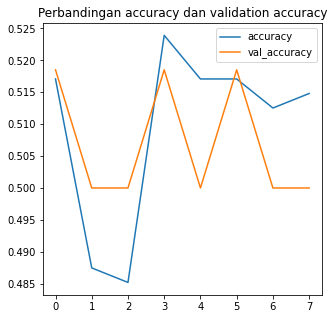

In [39]:
# plot accuracy dan val_accuracy
metrics_model[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Dari model yang telah dibuat diketahui bahwa:

- Dari loss dan validation loss pada mengalami exploding gradient, gap antara loss dan validation loss pun cukup jauh.
- sedangkan dari accuracy dan validation accuracy cenderung naik turun atau biasa disebut dengan exploding gradient.
- Telah digunakan early stopping pada training model dan model berhenti pada epoch ke 8.


# 8 - Model Evaluation

In [40]:
# definisikan label
num_label = ds_train.class_indices

# label dari test
y_test = test_df['label'].copy().map(num_label).astype('int')

In [41]:
# prediksi data test
ds_test.reset()
y_pred_test = model.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test))

6/6 [==============================] - 0s 40ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        29
           1       0.00      0.00      0.00        30

    accuracy                           0.49        59
   macro avg       0.25      0.50      0.33        59
weighted avg       0.24      0.49      0.32        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 49%. Hal ini menunjukkan model masih buruk dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing
- Secara keseluruhan sebenarnya model masih jelek secara nilai akurasi maka dari itu diperlukan model improvement pada tahap selanjutnya.

Confusion Matrix


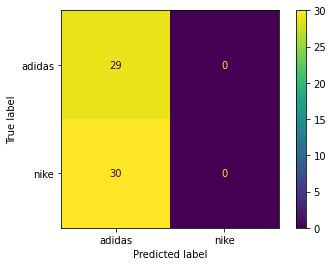

In [42]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat = confusion_matrix(y_test, y_pred_test)
dispay = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['adidas','nike'])
dispay.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 29 label adidas benar diprediksi sebagai adidas
- 0 label adidas salah diprediksi sebagai nike
- 0 label nike benar diprediksi sebagai nike
- 30 label nike salah diprediksi sebagai adidas

# 9 - Transfer Learning

In [43]:
# mendefinisikan callbacks untuk transfer learning
callbacks2= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            ModelCheckpoint('model2_best.hdf5', monitor='accuracy', save_best_only= True)
]

## 9.1 Transfer Learning Xception

penggunaan model Xception karena dinilai lebih efisien dari segi komputasi. Selain itu, Xception juga memiliki akurasi yang tinggi dibandingkan model lain pada dataset ImageNet, karena dibuat berdasarkan arsitektur Inception, tetapi dengan menggunakan depthwise separable convolutions.

In [44]:
# membersihkan sesi yang sedang berjalan di Keras.
tf.keras.backend.clear_session()

In [45]:
# Load pretrained model
pretrained_model_Xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model_Xception.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [46]:
# Create the model
model_Xception = Sequential()
model_Xception.add(pretrained_model_Xception)
model_Xception.add(Flatten())
model_Xception.add(Dense(128, activation='relu'))
model_Xception.add(Dense(128, activation='relu'))
model_Xception.add(Dense(1, activation='sigmoid'))

In [47]:
# model summary
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,140,393
Trainable params: 278,913
Non-trainable params: 20,861,480
_________________________________________________________________


Untuk model improvement menggunakan transfer learning sudah dibuat sesuai arsitektur di atas. Model transfer learning pertama menggunakan Xception. Selanjutnya hasilnya akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 128 juga, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [48]:
# Compile the model
model_Xception.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Xception = model_Xception.fit(ds_train, 
                      epochs=25, 
                      validation_data=ds_train, 
                      callbacks= callbacks2, 
                      verbose=1)


Epoch 1/25
44/44 [==============================] - 19s 347ms/step - loss: 0.6451 - accuracy: 0.6150 - val_loss: 0.5732 - val_accuracy: 0.6948
Epoch 2/25
44/44 [==============================] - 14s 331ms/step - loss: 0.5308 - accuracy: 0.7426 - val_loss: 0.4478 - val_accuracy: 0.7995
Epoch 3/25
44/44 [==============================] - 17s 401ms/step - loss: 0.4713 - accuracy: 0.7836 - val_loss: 0.4514 - val_accuracy: 0.7813
Epoch 4/25
44/44 [==============================] - 14s 323ms/step - loss: 0.4206 - accuracy: 0.8109 - val_loss: 0.4093 - val_accuracy: 0.8383
Epoch 5/25
44/44 [==============================] - 17s 402ms/step - loss: 0.4080 - accuracy: 0.8337 - val_loss: 0.3688 - val_accuracy: 0.8451
Epoch 6/25
44/44 [==============================] - 16s 378ms/step - loss: 0.3706 - accuracy: 0.8360 - val_loss: 0.3409 - val_accuracy: 0.8907
Epoch 7/25
44/44 [==============================] - 15s 337ms/step - loss: 0.3289 - accuracy: 0.8724 - val_loss: 0.3451 - val_accuracy: 0.8383

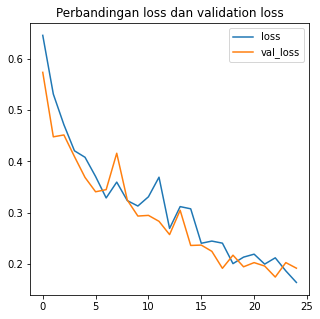

In [49]:
# ubah ke dataframe
metrics_model_Xception = pd.DataFrame(history_Xception.history)

# plot loss dan validation loss
metrics_model_Xception[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

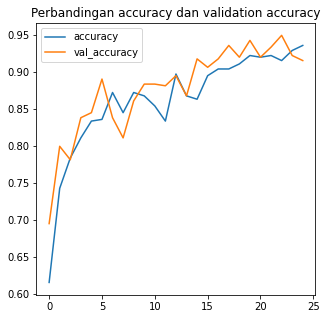

In [50]:
# plot accuracy dan val_accuracy
metrics_model_Xception[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada graph accuracy kita melihat bahwa pada accuracy pada train set sangat bagus dan juga meningkat tiap epochnya dan accuracy pada val set mengikuti di sekitar garis train set. Pada graph loss kita bisa melihat loss pada train set sangat bagus karena nilainya menurun tiap epoch dan pada epoch terakhir nilainya juga sangat rendah dan loss pada val set mengikuti disekitar garis loss train set sehingga gap tidak terlalu besar.

In [51]:
# prediksi data test
ds_test.reset()
y_pred_test_Xception = model_Xception.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_Xception = np.where(y_pred_test_Xception >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_Xception))

6/6 [==============================] - 1s 59ms/step
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.77      0.80      0.79        30

    accuracy                           0.78        59
   macro avg       0.78      0.78      0.78        59
weighted avg       0.78      0.78      0.78        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 78%. Hal ini menunjukkan model sudah cukup baik dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing.
- Secara keseluruhan sebenarnya model sudah cukup baik secara nilai akurasi.

Confusion Matrix


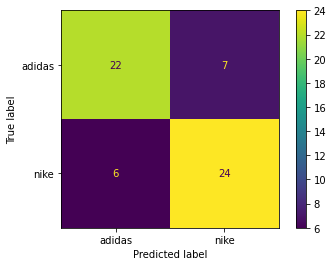

In [52]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat_Xception = confusion_matrix(y_test, y_pred_test_Xception)
dispay_Xception = ConfusionMatrixDisplay(confusion_matrix=confmat_Xception, display_labels=['adidas','nike'])
dispay_Xception.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 22 label adidas benar diprediksi sebagai adidas
- 7 label adidas salah diprediksi sebagai nike
- 24 label nike benar diprediksi sebagai nike
- 6 label nike salah diprediksi sebagai adidas

## 9.2 Transfer Learning ResNet50

In [53]:
# membersihkan sesi yang sedang berjalan di Keras.
tf.keras.backend.clear_session()

In [54]:
# Load pretrained model
pretrained_model_ResNet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model_ResNet50.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [55]:
# Create the model
model_ResNet50 = Sequential()
model_ResNet50.add(pretrained_model_ResNet50)
model_ResNet50.add(Flatten())
model_ResNet50.add(Dense(128, activation='relu'))
model_ResNet50.add(Dense(128, activation='relu'))
model_ResNet50.add(Dense(1, activation='sigmoid'))

In [56]:
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,866,625
Trainable params: 278,913
Non-trainable params: 23,587,712
_________________________________________________________________


Model transfer learning kelima menggunakan model ResNet50, untuk arsitektur yang dibuat sama seperti model Xception untuk membandingkan arsitektur model dengan model transfer learning yang digunakan. Selanjutnya hasilnya akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 128 juga, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [57]:
# Compile the model
model_ResNet50.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_ResNet50 = model_ResNet50.fit(ds_train, 
                      epochs=25, 
                      validation_data=ds_train, 
                      callbacks= callbacks2, 
                      verbose=1)

Epoch 1/25
44/44 [==============================] - 19s 337ms/step - loss: 0.6972 - accuracy: 0.5285 - val_loss: 0.7075 - val_accuracy: 0.5148
Epoch 2/25
44/44 [==============================] - 13s 307ms/step - loss: 0.6900 - accuracy: 0.5330 - val_loss: 0.6707 - val_accuracy: 0.5945
Epoch 3/25
44/44 [==============================] - 13s 305ms/step - loss: 0.6723 - accuracy: 0.6014 - val_loss: 0.6676 - val_accuracy: 0.5490
Epoch 4/25
44/44 [==============================] - 13s 304ms/step - loss: 0.6727 - accuracy: 0.5900 - val_loss: 0.6720 - val_accuracy: 0.5695
Epoch 5/25
44/44 [==============================] - 13s 302ms/step - loss: 0.6957 - accuracy: 0.5718 - val_loss: 0.6899 - val_accuracy: 0.5239
Epoch 6/25
44/44 [==============================] - 13s 302ms/step - loss: 0.6736 - accuracy: 0.5854 - val_loss: 0.6552 - val_accuracy: 0.6492
Epoch 7/25
44/44 [==============================] - 16s 370ms/step - loss: 0.6648 - accuracy: 0.5626 - val_loss: 0.6567 - val_accuracy: 0.5626

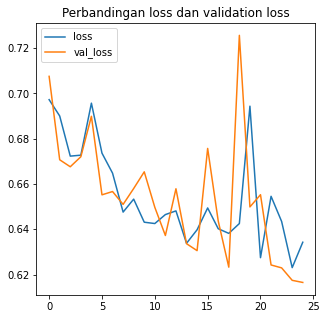

In [58]:
# ubah ke dataframe
metrics_model_ResNet50 = pd.DataFrame(history_ResNet50.history)

# plot loss dan validation loss
metrics_model_ResNet50[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

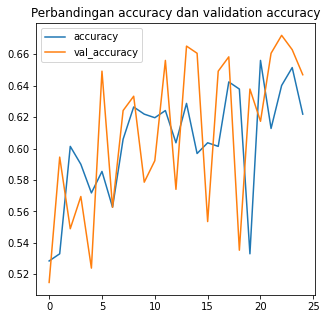

In [59]:
# plot accuracy dan val_accuracy
metrics_model_ResNet50[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada graph accuracy kita melihat bahwa pada accuracy pada train set mengalami naik turun yang tidak stabil. Pada graph loss kita bisa melihat loss pada train set walaupun terdapat graph yang unstable namun nilai loss terus menurun.

In [60]:
# prediksi data test
ds_test.reset()
y_pred_test_ResNet50 = model_ResNet50.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_ResNet50 = np.where(y_pred_test_ResNet50 >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_ResNet50))

6/6 [==============================] - 1s 52ms/step
              precision    recall  f1-score   support

           0       0.61      0.38      0.47        29
           1       0.56      0.77      0.65        30

    accuracy                           0.58        59
   macro avg       0.59      0.57      0.56        59
weighted avg       0.59      0.58      0.56        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 58%. Hal ini menunjukkan model masih buruk dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing.

Confusion Matrix


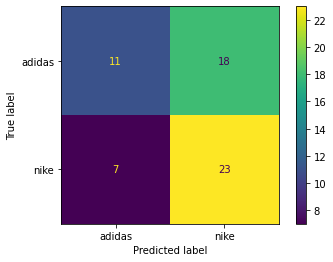

In [61]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat_ResNet50 = confusion_matrix(y_test, y_pred_test_ResNet50)
dispay_ResNet50 = ConfusionMatrixDisplay(confusion_matrix=confmat_ResNet50, display_labels=['adidas','nike'])
dispay_ResNet50.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 11 label adidas benar diprediksi sebagai adidas
- 18 label adidas salah diprediksi sebagai nike
- 23 label nike benar diprediksi sebagai nike
- 7 label nike salah diprediksi sebagai adidas

## 9.3 Transfer Learning InceptionV3

In [62]:
# membersihkan sesi yang sedang berjalan di Keras.
tf.keras.backend.clear_session()

In [63]:
# Load pretrained model
pretrained_model_InceptionV3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model_InceptionV3.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [64]:
# Create the model
model_InceptionV3 = Sequential()
model_InceptionV3.add(pretrained_model_InceptionV3)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(128, activation='relu'))
model_InceptionV3.add(Dense(128, activation='relu'))
model_InceptionV3.add(Dense(1, activation='sigmoid'))

In [65]:
model_InceptionV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,081,697
Trainable params: 278,913
Non-trainable params: 21,802,784
_________________________________________________________________


Model transfer learning ketiga menggunakan model InceptionV3, untuk arsitektur yang dibuat sama seperti model Xception untuk membandingkan arsitektur model dengan model transfer learning yang digunakan. Selanjutnya hasilnya akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 128 juga, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [66]:
# Compile the model
model_InceptionV3.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_InceptionV3 = model_InceptionV3.fit(ds_train, 
                      epochs=25, 
                      validation_data=ds_train, 
                      callbacks= callbacks2, 
                      verbose=1)

Epoch 1/25
44/44 [==============================] - 20s 336ms/step - loss: 0.6132 - accuracy: 0.6674 - val_loss: 0.4566 - val_accuracy: 0.8109
Epoch 2/25
44/44 [==============================] - 16s 375ms/step - loss: 0.4626 - accuracy: 0.7836 - val_loss: 0.3927 - val_accuracy: 0.8383
Epoch 3/25
44/44 [==============================] - 13s 288ms/step - loss: 0.4498 - accuracy: 0.7950 - val_loss: 0.3655 - val_accuracy: 0.8451
Epoch 4/25
44/44 [==============================] - 14s 319ms/step - loss: 0.3759 - accuracy: 0.8474 - val_loss: 0.3522 - val_accuracy: 0.8451
Epoch 5/25
44/44 [==============================] - 15s 343ms/step - loss: 0.3599 - accuracy: 0.8428 - val_loss: 0.3428 - val_accuracy: 0.8428
Epoch 6/25
44/44 [==============================] - 13s 301ms/step - loss: 0.3616 - accuracy: 0.8269 - val_loss: 0.3278 - val_accuracy: 0.8542
Epoch 7/25
44/44 [==============================] - 17s 383ms/step - loss: 0.3145 - accuracy: 0.8702 - val_loss: 0.3290 - val_accuracy: 0.8588

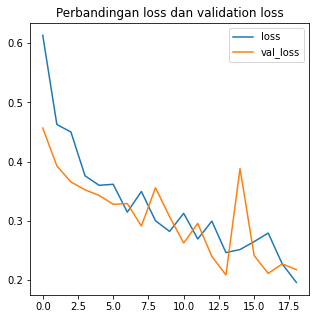

In [67]:
# ubah ke dataframe
metrics_model_InceptionV3 = pd.DataFrame(history_InceptionV3.history)

# plot loss dan validation loss
metrics_model_InceptionV3[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

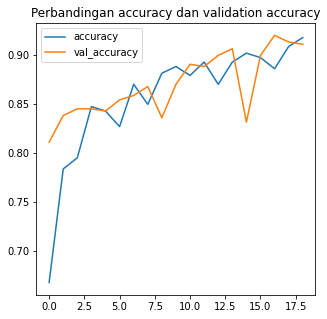

In [68]:
# plot accuracy dan val_accuracy
metrics_model_InceptionV3[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada proses training model mengalami early stoping pada epoch ke 19, hal ini disebabkan dari val_loss tidak mengalami penurunan sehingga terdeteksi selama proses training dan dilakukan pemberhentian training. Pada graph accuracy kita melihat bahwa pada accuracy pada train set mengalami naik turun namun sangat bagus dan juga terus meningkat di tiap epochnya dan accuracy pada val set mengikuti di sekitar garis train set dengan gap yang sedikit. Pada graph loss kita bisa melihat loss pada train set sangat bagus karena nilainya menurun tiap epoch dan loss pada val set terjadi naik turun pada prosesnya namun tetap menurun nilainya.

In [69]:
# prediksi data test
ds_test.reset()
y_pred_test_InceptionV3 = model_InceptionV3.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_InceptionV3 = np.where(y_pred_test_InceptionV3 >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_InceptionV3))

6/6 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.86      0.66      0.75        29
           1       0.73      0.90      0.81        30

    accuracy                           0.78        59
   macro avg       0.80      0.78      0.78        59
weighted avg       0.80      0.78      0.78        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 78%. Hal ini menunjukkan model sudah cukup baik dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing.
- Secara keseluruhan sebenarnya model sudah cukup baik secara nilai akurasi.

Confusion Matrix


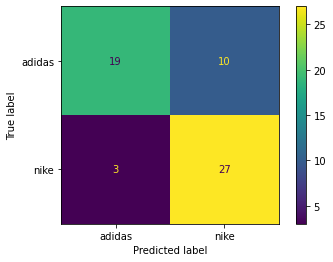

In [70]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat_InceptionV3 = confusion_matrix(y_test, y_pred_test_InceptionV3)
dispay_InceptionV3 = ConfusionMatrixDisplay(confusion_matrix=confmat_InceptionV3, display_labels=['adidas','nike'])
dispay_InceptionV3.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 19 label adidas benar diprediksi sebagai adidas
- 10 label adidas salah diprediksi sebagai nike
- 27 label nike benar diprediksi sebagai nike
- 3 label nike salah diprediksi sebagai adidas

## 9.4 Transfer Learning VGG16

In [71]:
# membersihkan sesi yang sedang berjalan di Keras.
tf.keras.backend.clear_session()

In [72]:
# Load pretrained model
pretrained_model_VGG16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model_VGG16.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [73]:
# Create the model
model_VGG16 = Sequential()
model_VGG16.add(pretrained_model_VGG16)
model_VGG16.add(Flatten())
model_VGG16.add(Dense(128, activation='relu'))
model_VGG16.add(Dense(128, activation='relu'))
model_VGG16.add(Dense(1, activation='sigmoid'))

In [74]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,796,993
Trainable params: 82,305
Non-trainable params: 14,714,688
_________________________________________________________________


Model transfer learning keempat menggunakan model VGG16, untuk arsitektur yang dibuat sama seperti model Xception untuk membandingkan arsitektur model dengan model transfer learning yang digunakan. Selanjutnya hasilnya akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 128 juga, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [75]:
# Compile the model
model_VGG16.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG16 = model_VGG16.fit(ds_train, 
                      epochs=25, 
                      validation_data=ds_train, 
                      callbacks= callbacks2, 
                      verbose=1)

Epoch 1/25
44/44 [==============================] - 19s 380ms/step - loss: 0.6838 - accuracy: 0.5353 - val_loss: 0.6596 - val_accuracy: 0.6492
Epoch 2/25
44/44 [==============================] - 21s 478ms/step - loss: 0.6428 - accuracy: 0.7130 - val_loss: 0.6282 - val_accuracy: 0.6765
Epoch 3/25
44/44 [==============================] - 16s 366ms/step - loss: 0.6164 - accuracy: 0.7084 - val_loss: 0.5958 - val_accuracy: 0.7267
Epoch 4/25
44/44 [==============================] - 14s 310ms/step - loss: 0.5784 - accuracy: 0.7472 - val_loss: 0.5593 - val_accuracy: 0.7449
Epoch 5/25
44/44 [==============================] - 15s 344ms/step - loss: 0.5628 - accuracy: 0.7380 - val_loss: 0.5150 - val_accuracy: 0.8155
Epoch 6/25
44/44 [==============================] - 16s 362ms/step - loss: 0.5047 - accuracy: 0.7859 - val_loss: 0.5389 - val_accuracy: 0.7244
Epoch 7/25
44/44 [==============================] - 14s 330ms/step - loss: 0.5073 - accuracy: 0.8041 - val_loss: 0.4858 - val_accuracy: 0.8041

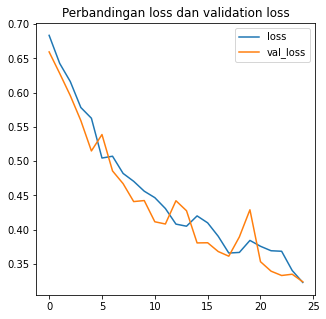

In [76]:
# ubah ke dataframe
metrics_model_VGG16 = pd.DataFrame(history_VGG16.history)

# plot loss dan validation loss
metrics_model_VGG16[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

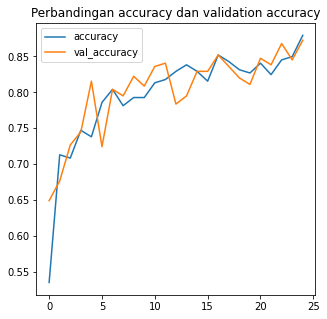

In [77]:
# plot accuracy dan val_accuracy
metrics_model_VGG16[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada graph accuracy kita melihat bahwa gap pada accuracy dan validation accuracy tidak terlalu jauh dan terdapat beberapa epoch yang tidak selaras antara accuracy dan val_accuracy namun tetap bagus karena mengalami peningkatan pada tiap epochnya. Pada graph loss juga dapat dilihat kadang tidak selaras prosesnya, namun tetap menurun di setiap epoch nya.

In [78]:
# prediksi data test
ds_test.reset()
y_pred_test_VGG16 = model_VGG16.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_VGG16 = np.where(y_pred_test_VGG16 >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_VGG16))

6/6 [==============================] - 1s 76ms/step
              precision    recall  f1-score   support

           0       0.79      0.52      0.62        29
           1       0.65      0.87      0.74        30

    accuracy                           0.69        59
   macro avg       0.72      0.69      0.68        59
weighted avg       0.72      0.69      0.68        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 69%. Hal ini menunjukkan model masih kurang baik dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing.

Confusion Matrix


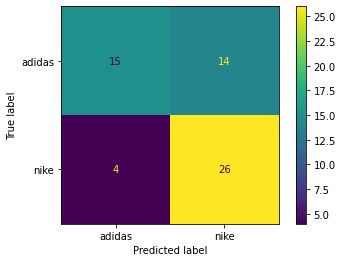

In [79]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat_VGG16 = confusion_matrix(y_test, y_pred_test_VGG16)
dispay_VGG16 = ConfusionMatrixDisplay(confusion_matrix=confmat_VGG16, display_labels=['adidas','nike'])
dispay_VGG16.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 15 label adidas benar diprediksi sebagai adidas
- 14 label adidas salah diprediksi sebagai nike
- 26 label nike benar diprediksi sebagai nike
- 4 label nike salah diprediksi sebagai adidas

## 9.5 Transfer Learning DenseNet

In [80]:
# membersihkan sesi yang sedang berjalan di Keras.
tf.keras.backend.clear_session()

In [81]:
# Load pretrained model
pretrained_model_DenseNet121 = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model_DenseNet121.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [82]:
# Create the model
model_DenseNet121 = Sequential()
model_DenseNet121.add(pretrained_model_DenseNet121)
model_DenseNet121.add(Flatten())
model_DenseNet121.add(Dense(128, activation='relu'))
model_DenseNet121.add(Dense(128, activation='relu'))
model_DenseNet121.add(Dense(1, activation='sigmoid'))

In [83]:
model_DenseNet121.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,185,345
Trainable params: 147,841
Non-trainable params: 7,037,504
_________________________________________________________________


Model transfer learning kelima menggunakan model DenseNet121, untuk arsitektur yang dibuat sama seperti model Xception untuk membandingkan arsitektur model dengan model transfer learning yang digunakan. Selanjutnya hasilnya akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 128 juga, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [84]:
# Compile the model
model_DenseNet121.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_DenseNet121 = model_DenseNet121.fit(ds_train, 
                      epochs=25, 
                      validation_data=ds_train, 
                      callbacks= callbacks2, 
                      verbose=1)

Epoch 1/25
44/44 [==============================] - 24s 375ms/step - loss: 0.5810 - accuracy: 0.6970 - val_loss: 0.4694 - val_accuracy: 0.7904
Epoch 2/25
44/44 [==============================] - 13s 308ms/step - loss: 0.4350 - accuracy: 0.8087 - val_loss: 0.4123 - val_accuracy: 0.8087
Epoch 3/25
44/44 [==============================] - 15s 341ms/step - loss: 0.4210 - accuracy: 0.8200 - val_loss: 0.3644 - val_accuracy: 0.8497
Epoch 4/25
44/44 [==============================] - 21s 470ms/step - loss: 0.3481 - accuracy: 0.8314 - val_loss: 0.3435 - val_accuracy: 0.8383
Epoch 5/25
44/44 [==============================] - 16s 372ms/step - loss: 0.3290 - accuracy: 0.8679 - val_loss: 0.3256 - val_accuracy: 0.8542
Epoch 6/25
44/44 [==============================] - 18s 420ms/step - loss: 0.3269 - accuracy: 0.8747 - val_loss: 0.2888 - val_accuracy: 0.8884
Epoch 7/25
44/44 [==============================] - 14s 332ms/step - loss: 0.3019 - accuracy: 0.8679 - val_loss: 0.2721 - val_accuracy: 0.8929

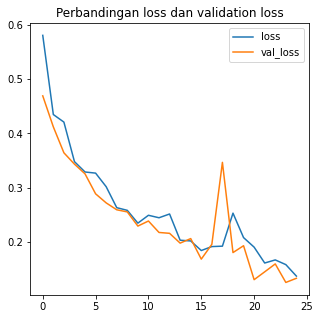

In [85]:
# ubah ke dataframe
metrics_model_DenseNet121 = pd.DataFrame(history_DenseNet121.history)

# plot loss dan validation loss
metrics_model_DenseNet121[['loss', 'val_loss']].plot(figsize=(5,5))
plt.title('Perbandingan loss dan validation loss')
plt.show()

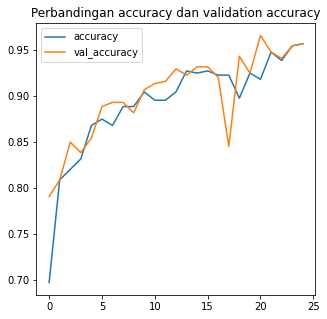

In [86]:
# plot accuracy dan val_accuracy
metrics_model_DenseNet121[['accuracy', 'val_accuracy']].plot(figsize=(5,5))
plt.title('Perbandingan accuracy dan validation accuracy')
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy.Pada graph accuracy kita melihat bahwa pada accuracy pada train set sangat bagus dan juga meningkat tiap epochnya dan accuracy pada val set mengikuti di sekitar garis train set walaupun terkadang ada gap diantara keduanya. Pada graph loss kita bisa melihat loss pada train set sangat bagus karena nilainya menurun tiap epoch walaupun di pertengahan terjadi unstable namun hasil training tetap menurun dan pada epoch terakhir nilainya juga sangat rendah dan loss pada val set mengikuti disekitar garis loss train set sehingga gap tidak terlalu besar.

In [87]:
# prediksi data test
ds_test.reset()
y_pred_test_DenseNet121 = model_DenseNet121.predict(ds_test, steps= len(ds_test))
# atur threshold 0.5
y_pred_test_DenseNet121 = np.where(y_pred_test_DenseNet121 >= 0.5, 1, 0)
# hasil dari classification report
print(classification_report(y_test, y_pred_test_DenseNet121))

6/6 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.94      0.59      0.72        29
           1       0.71      0.97      0.82        30

    accuracy                           0.78        59
   macro avg       0.83      0.78      0.77        59
weighted avg       0.82      0.78      0.77        59



- Karena data antara label 0 dan 1 hanya selisih 1 data maka nilai metrics yang digunakan adalah akurasi. Terlihat bahwa nilai akurasi pada test yaitu 78%. Hal ini menunjukkan model belum terlalu baik dalam melakukan klasifikasi secara benar.
- Digunakan threshold klasifikasi 0.5 untuk menghindari bias antar class label masing-masing.
- Secara keseluruhan sebenarnya model belum terlalu baik secara nilai akurasi.

Confusion Matrix


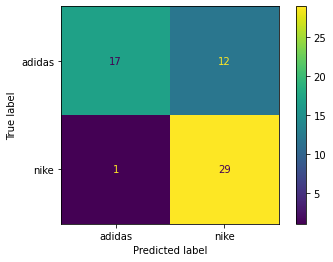

In [88]:
# hasil dari confusion matrix untuk melihat true positif dan true negatif
print('Confusion Matrix')
confmat_DenseNet121 = confusion_matrix(y_test, y_pred_test_DenseNet121)
dispay_DenseNet121 = ConfusionMatrixDisplay(confusion_matrix=confmat_DenseNet121, display_labels=['adidas','nike'])
dispay_DenseNet121.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :

- 17 label adidas benar diprediksi sebagai adidas
- 12 label adidas salah diprediksi sebagai nike
- 29 label nike benar diprediksi sebagai nike
- 1 label nike salah diprediksi sebagai adidas

# 10 - Model Inference

## 10.1 Load Model

Model yang digunakan untuk model inference bukan model basic maupun model hasil transfer learning yang dipilih sebagai model terbaik. Model inference yang digunakan adalah model dengan akurasi terbaik menurut Model check point secara otomatis dipilih pada saat proses training.

In [89]:
# load best model
best_model = load_model('model2_best.hdf5')
best_model
     

Saving img1.jpeg to img1.jpeg


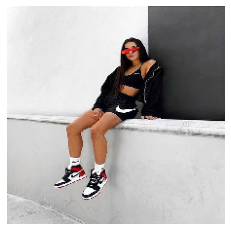

1/1 [==============================] - 3s 3s/step
[[3.9762312e-12]]
adidas


In [90]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(224,224)) # ukuran harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = best_model.predict(images) #gunakan model yang terbaik
  print(classes) 
  if classes[0][0] < 0.5:
    print('adidas')
  else:
    print('nike')

Saving img3.jpeg to img3.jpeg


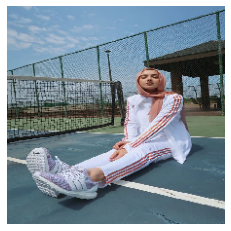

1/1 [==============================] - 0s 29ms/step
[[0.02081848]]
adidas


In [91]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(224, 224)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = best_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] < 0.5:
    print('adidas')
  else:
    print('nike')

Saving img4.jpeg to img4.jpeg


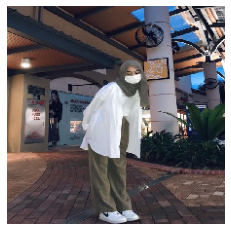

1/1 [==============================] - 0s 32ms/step
[[0.00215632]]
adidas


In [92]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(224, 224)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = best_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] < 0.5:
    print('adidas')
  else:
    print('nike')

Saving img14.jpeg to img14.jpeg


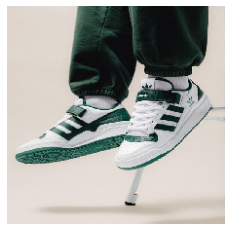

1/1 [==============================] - 0s 30ms/step
[[6.111853e-08]]
adidas


In [93]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(224, 224)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = best_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] < 0.5:
    print('adidas')
  else:
    print('nike')

Saving img11.jpeg to img11.jpeg


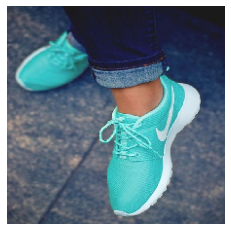

1/1 [==============================] - 0s 33ms/step
[[1.00858515e-05]]
nike


In [94]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(224, 224)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = best_model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 0:
    print('adidas')
  else:
    print('nike')

Model hasil improvement kita belum berhasil sepenuhnya memprediksi gambar yang diupload dengan benar. Dari total 5 gambar hanya 3 gambar yang berhasil di prediksi dengan benar.



# 11 - Kesimpulan

Pada assigment ini dibuat model computer vision menggunakan CNN untu melakukan klasifikasi gambar. Dataset yang digunakan adalah Nike,Adidas Shoes for Image Classification. Dataset yang digunakan telah terpisah antara test, validation dan train.

**1. EDA**
- Dari proses EDA dapat diketahui bahwa jumlah label adidas dan nike memiliki jumlah yang balance karena perbedaan antar keduanya hanya sedikit.
- Dari visualisasi sample untuk kelas adidas dapat diketahui hampir seluruh gambar sepatu Adidas terdapat garis stip tiga pada bagian luar dari sepatunya. Namun terdapat gambar yang salah label, karena terdapat sepatu nike yang di klasifikasikan sebagai label adidas, sehingga memungkinkan terjadinya salah prediksi yang dihasilkan oleh model. Sedangkan untuk kelas nike juga memiliki ciri khas logo Nike atau 'centang' pada bagian luar dari sepatu.
- Label adidas diwakilkan oleh 0 dan nike diwakilkan oleh 1.

**2. Preprosessing**

Pada proses preprosessing dilakukan rescaling pada semua ukuran gambar menjadi 224x224 agar saat gambar masuk proses training model tidak terjadinya error karena perbedaan ukuran gambar. Disini juga dilakukan augmentasi berupa:
- Rotasi gambar secara random sejauh 0.2 derajat.
- Menggeser gambar sebanyak 20% dari total width.
- Menggeser gambar sebanyak 20% dari total height.
- Tranvesi/memiringkan gambar sejauh 0.2 derajat.
- Zoom gambar sejauh 0.2.
- Melakukan horizontal flip pada gambar
- Melakukan vertikal flip pada gambar

**3. Model Analysis**
- telah dilakukan model improvement dengan menggunakan 5 metode transfer learning, tetapi untuk validation loss dan validation akurasi sering mengalami ketidakstabilan dan exploiding. Untuk loss dan akurasi train menunjukkan bahwa perubahan nilai penurunan loss dan peningkatan akurasi mengalami perubahan yang signifikan dan baik. Tetapi model ini tidak dapat dikatakan baik karena masih mengalami exploiding dan terdapat perbedaan antara train dan validation.
- Ada 5 model transfer learning yang dilakukan tetapi hasil keduanya masih kurang baik.
- Dari perbandingan classification report test, hasil akurasi dari model basic menunjukkan 49%, untuk model transfer learning Xception 78%, untuk model transfer learning ResNet50 58%, untuk model transfer learning InceptionV3 78%, untuk model transfer learning VGG16 69%, dan untuk model transfer learning DenseNet 78%.
- Model inference yang digunakan berdasarkan best model yang dimonitoring oleh model check point. Masih ada beberapa data yang salah prediksi sehingga masih perlu perbaikan.

Secara keseluruhan model yang dibuat belum cukup baik karena masih terdeteksi overfit baik dari loss dan akurasi. Perlunya dilakukan eksplorasi lebih lanjut untuk menenemukan arsitektur model terbaik untuk dataset ini. Proses training yang cukup lama dan kendala device sehingga kurangnya proses eksplorasi lebih lanjut. Pentingnya juga peningkatan terhadap akurasi dari model.

